<a href="https://colab.research.google.com/github/ArifAygun/Advanced-Pandas/blob/main/AA_Graduate_Project_22_0306.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quality Prediction of Iron Ore Mining Flotation Process - Part:2**

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, norm, boxcox, mstats
from sklearn.preprocessing import StandardScaler
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

In [72]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Flotation/
flotation = pd.read_csv('Flotation_Plant_Grouped.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Flotation


##**4. Data Preprocessing**

###**4.1. Dataset information**

In [73]:
flotation.head().T

,0,1,2,3,4
iron_feed,55.200000,55.200000,55.200000,55.200000,55.200000
silica_feed,16.980000,16.980000,16.980000,16.980000,16.980000
starch_flow,323.277098,313.071046,347.948294,334.803744,341.273712
amina_flow,578.786678,537.527989,591.906744,592.637869,619.719955
pulp_flow,398.753368,399.937080,398.763806,399.876845,399.696537
pulp_pH,10.113621,10.129200,10.048444,9.922440,9.746158
pulp_density,1.729598,1.667943,1.733000,1.730179,1.765819
airflow_col1,251.166672,249.868246,250.161328,250.151917,249.931966
airflow_col2,250.226086,250.191149,250.104167,250.023107,250.101621
airflow_col3,250.178287,250.055474,250.046350,250.134119,250.003096


In [74]:
flotation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4097 entries, 0 to 4096
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   iron_feed     4097 non-null   float64
 1   silica_feed   4097 non-null   float64
 2   starch_flow   4097 non-null   float64
 3   amina_flow    4097 non-null   float64
 4   pulp_flow     4097 non-null   float64
 5   pulp_pH       4097 non-null   float64
 6   pulp_density  4097 non-null   float64
 7   airflow_col1  4097 non-null   float64
 8   airflow_col2  4097 non-null   float64
 9   airflow_col3  4097 non-null   float64
 10  airflow_col4  4097 non-null   float64
 11  airflow_col5  4097 non-null   float64
 12  airflow_col6  4097 non-null   float64
 13  airflow_col7  4097 non-null   float64
 14  level_col1    4097 non-null   float64
 15  level_col2    4097 non-null   float64
 16  level_col3    4097 non-null   float64
 17  level_col4    4097 non-null   float64
 18  level_col5    4097 non-null 

### **4.5. Scaling**

In [75]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_scale = flotation.columns
scaled_data = scaler.fit_transform(flotation[columns_to_scale])
flotation_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)

unscaled_stats = flotation.describe().loc[['mean', 'std']].T
unscaled_stats.columns = ['Unscaled Mean', 'Unscaled Std']

scaled_stats = flotation_scaled.describe().loc[['mean', 'std']].T
scaled_stats.columns = ['Scaled Mean', 'Scaled Std']

combined_stats = pd.concat([unscaled_stats, scaled_stats], axis=1)

In [76]:
flotation_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
iron_feed,4097.0,8.324640e-16,1.000122,-2.628048,-0.702778,-0.041633,0.664106,1.839044
silica_feed,4097.0,1.387440e-16,1.000122,-1.959885,-0.839047,-0.117774,0.726895,2.754099
starch_flow,4097.0,-6.659712e-16,1.000122,-2.542165,-0.588605,-0.029474,0.476378,6.746484
amina_flow,4097.0,2.011788e-16,1.000122,-2.930281,-0.622850,0.170399,0.732843,2.973005
pulp_flow,4097.0,1.886918e-15,1.000122,-2.478006,0.150374,0.270405,0.358968,2.448577
pulp_pH,4097.0,-5.965992e-15,1.000122,-2.691451,-0.602111,0.073996,0.696364,2.756703
pulp_density,4097.0,7.630920e-17,1.000122,-2.510553,-0.454680,0.240860,0.647239,2.388862
airflow_col1,4097.0,-1.664928e-16,1.000122,-3.545550,-1.022275,0.669485,0.673353,1.093054
airflow_col2,4097.0,5.549760e-17,1.000122,-3.364069,-0.919843,0.760400,0.775753,1.111130
airflow_col3,4097.0,-1.553933e-15,1.000122,-3.661521,-1.092364,0.662773,0.664950,0.764915


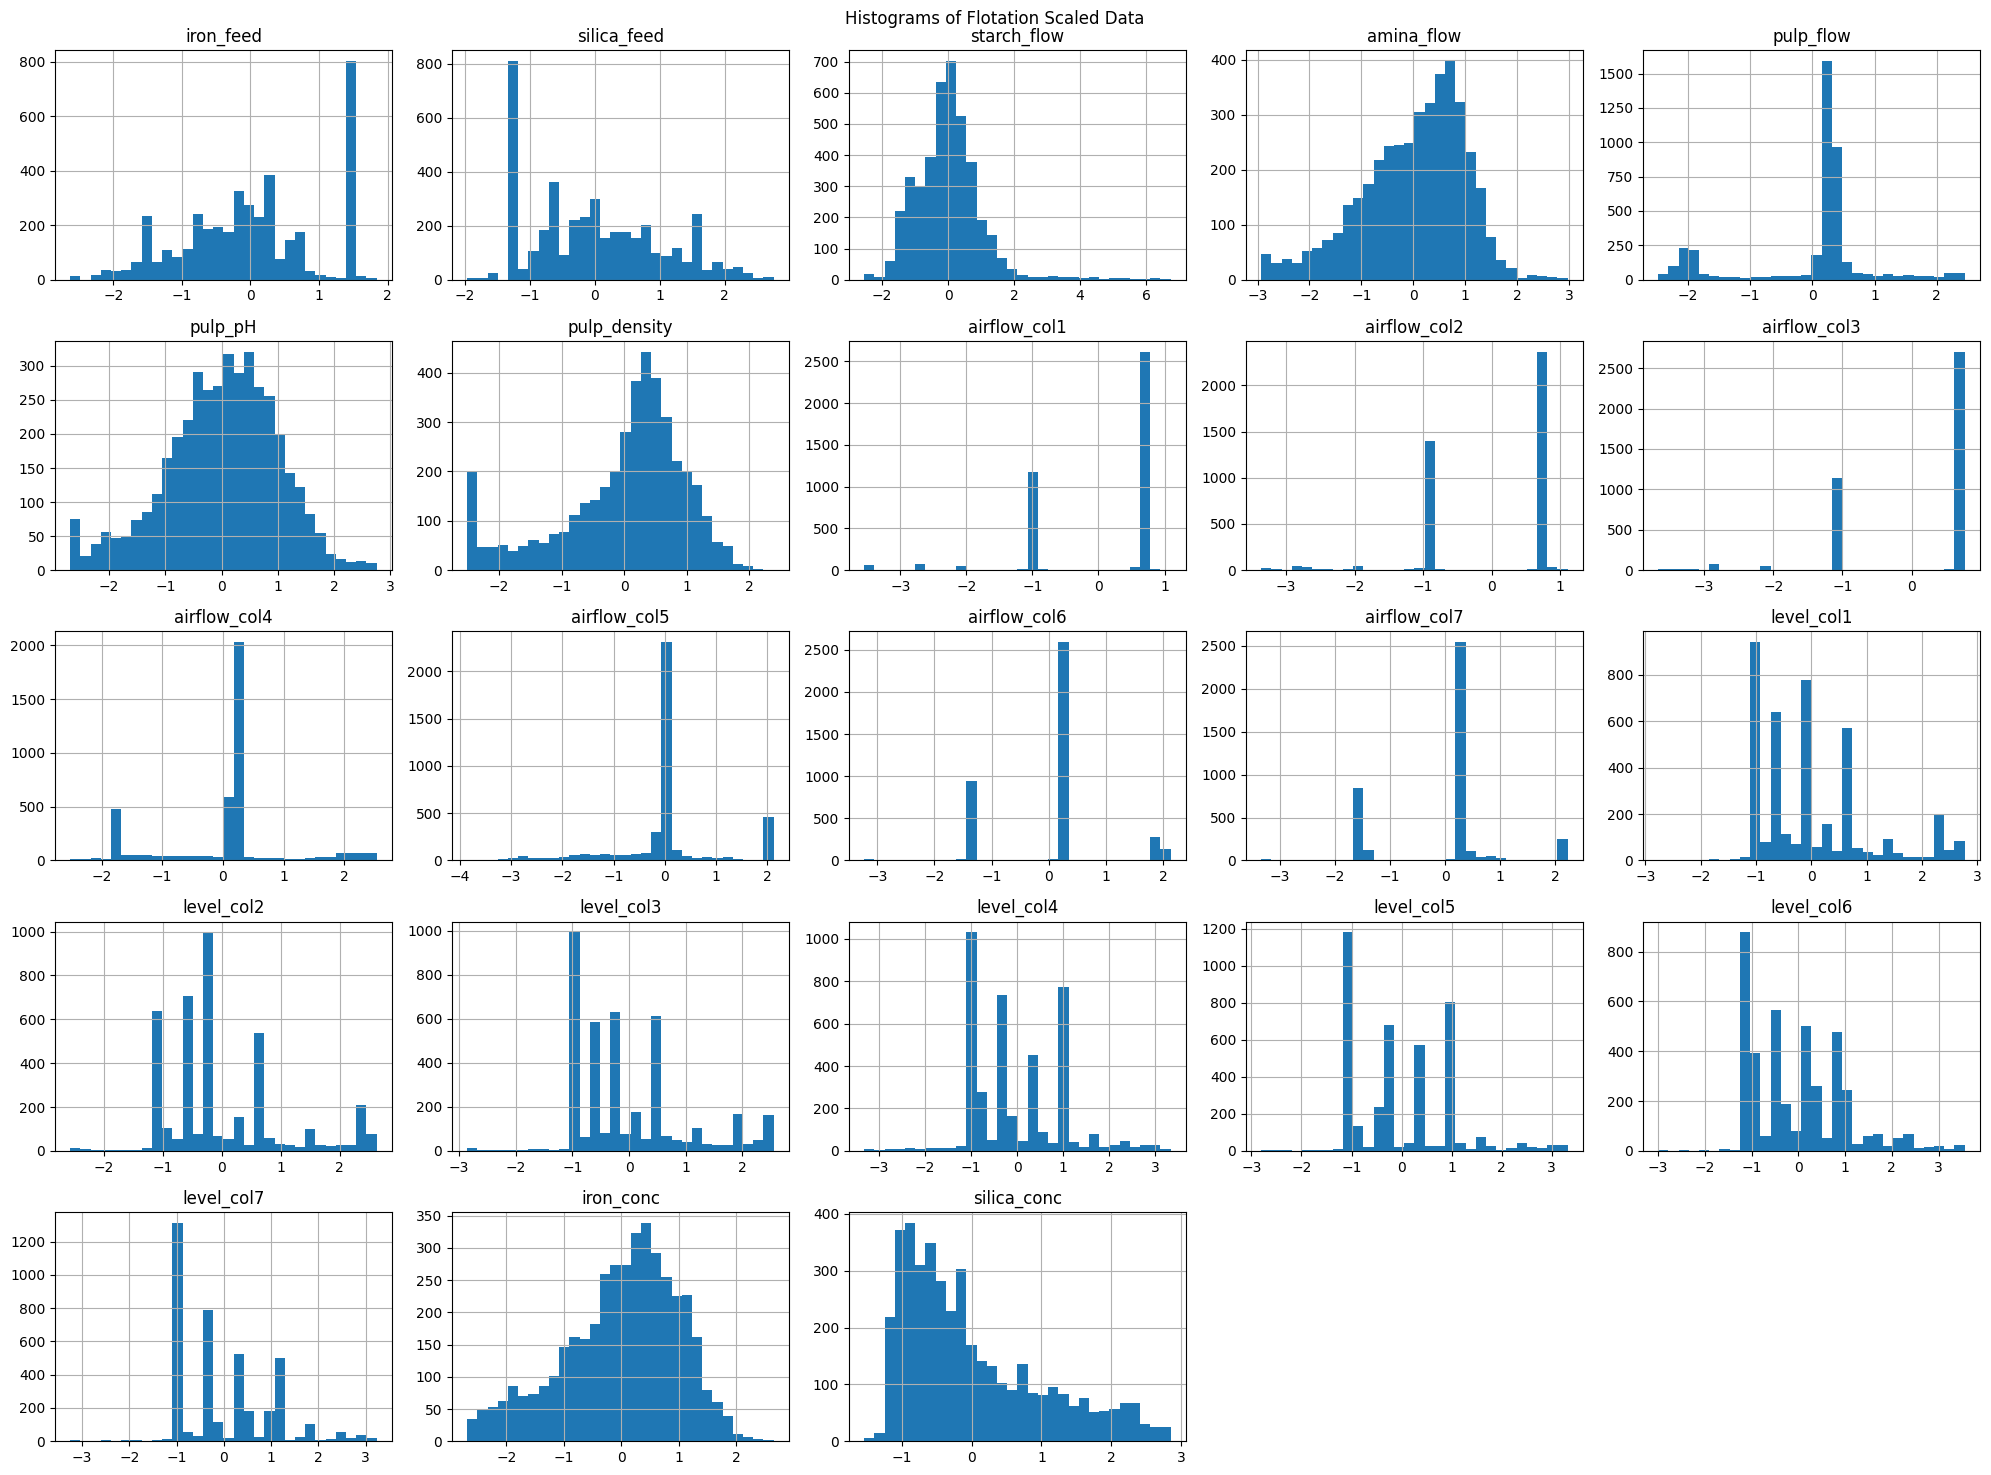

In [77]:
flotation_scaled.hist(figsize=(20, 15), bins=30)

plt.xlabel("Value")
plt.ylabel("Frequency")
plt.suptitle("Histograms of Flotation Scaled Data")

plt.tight_layout()

plt.show()

###**4.6. Corellation between the variables**

In [78]:
flotation_scaled.corr()

,iron_feed,silica_feed,starch_flow,amina_flow,pulp_flow,pulp_pH,pulp_density,airflow_col1,airflow_col2,airflow_col3,...,airflow_col7,level_col1,level_col2,level_col3,level_col4,level_col5,level_col6,level_col7,iron_conc,silica_conc
iron_feed,1.000000,-0.971833,-0.012717,-0.096238,0.186376,0.007447,-0.136398,-0.062829,-0.173618,-0.062608,...,-0.017228,0.031526,0.022945,0.016548,0.019283,0.026259,0.004367,0.030148,0.055456,-0.077109
silica_feed,-0.971833,1.000000,0.029068,0.085928,-0.174850,0.008366,0.113419,0.092421,0.187098,0.084740,...,0.047742,-0.040979,-0.040772,-0.024709,-0.040812,-0.049344,-0.023112,-0.054369,-0.044192,0.072776
starch_flow,-0.012717,0.029068,1.000000,0.039730,0.047833,0.230231,-0.118436,0.104599,0.113819,0.134941,...,0.139334,-0.198806,-0.166992,-0.137651,0.037623,0.044602,0.058808,0.015631,0.034950,-0.043254
amina_flow,-0.096238,0.085928,0.039730,1.000000,0.237698,0.134097,0.659852,0.121960,0.136965,0.111382,...,0.091266,-0.276231,-0.235440,-0.290003,-0.213123,-0.242181,-0.245009,-0.199479,-0.120417,0.171188
pulp_flow,0.186376,-0.174850,0.047833,0.237698,1.000000,0.138734,0.020162,-0.160514,-0.140517,-0.164090,...,-0.171500,-0.017236,-0.020330,-0.079746,-0.008856,0.005369,-0.023545,0.024683,0.096455,0.009754
pulp_pH,0.007447,0.008366,0.230231,0.134097,0.138734,1.000000,0.122764,0.168391,0.152147,0.199267,...,0.188266,-0.179804,-0.172865,-0.155092,0.057743,0.014351,-0.089912,0.022193,0.197910,-0.151390
pulp_density,-0.136398,0.113419,-0.118436,0.659852,0.020162,0.122764,1.000000,-0.005872,0.028603,-0.034911,...,-0.060513,-0.100675,-0.078463,-0.139910,-0.101537,-0.161884,-0.121059,-0.100247,0.016782,0.050890
airflow_col1,-0.062829,0.092421,0.104599,0.121960,-0.160514,0.168391,-0.005872,1.000000,0.866602,0.959976,...,0.678029,-0.476614,-0.472075,-0.406811,-0.074526,-0.103307,-0.141264,-0.128489,0.099325,-0.220847
airflow_col2,-0.173618,0.187098,0.113819,0.136965,-0.140517,0.152147,0.028603,0.866602,1.000000,0.879135,...,0.617616,-0.473867,-0.477461,-0.407485,-0.092445,-0.128454,-0.141335,-0.134058,0.060227,-0.171592
airflow_col3,-0.062608,0.084740,0.134941,0.111382,-0.164090,0.199267,-0.034911,0.959976,0.879135,1.000000,...,0.680862,-0.475383,-0.467455,-0.399045,-0.056629,-0.072604,-0.119034,-0.099591,0.100833,-0.220474


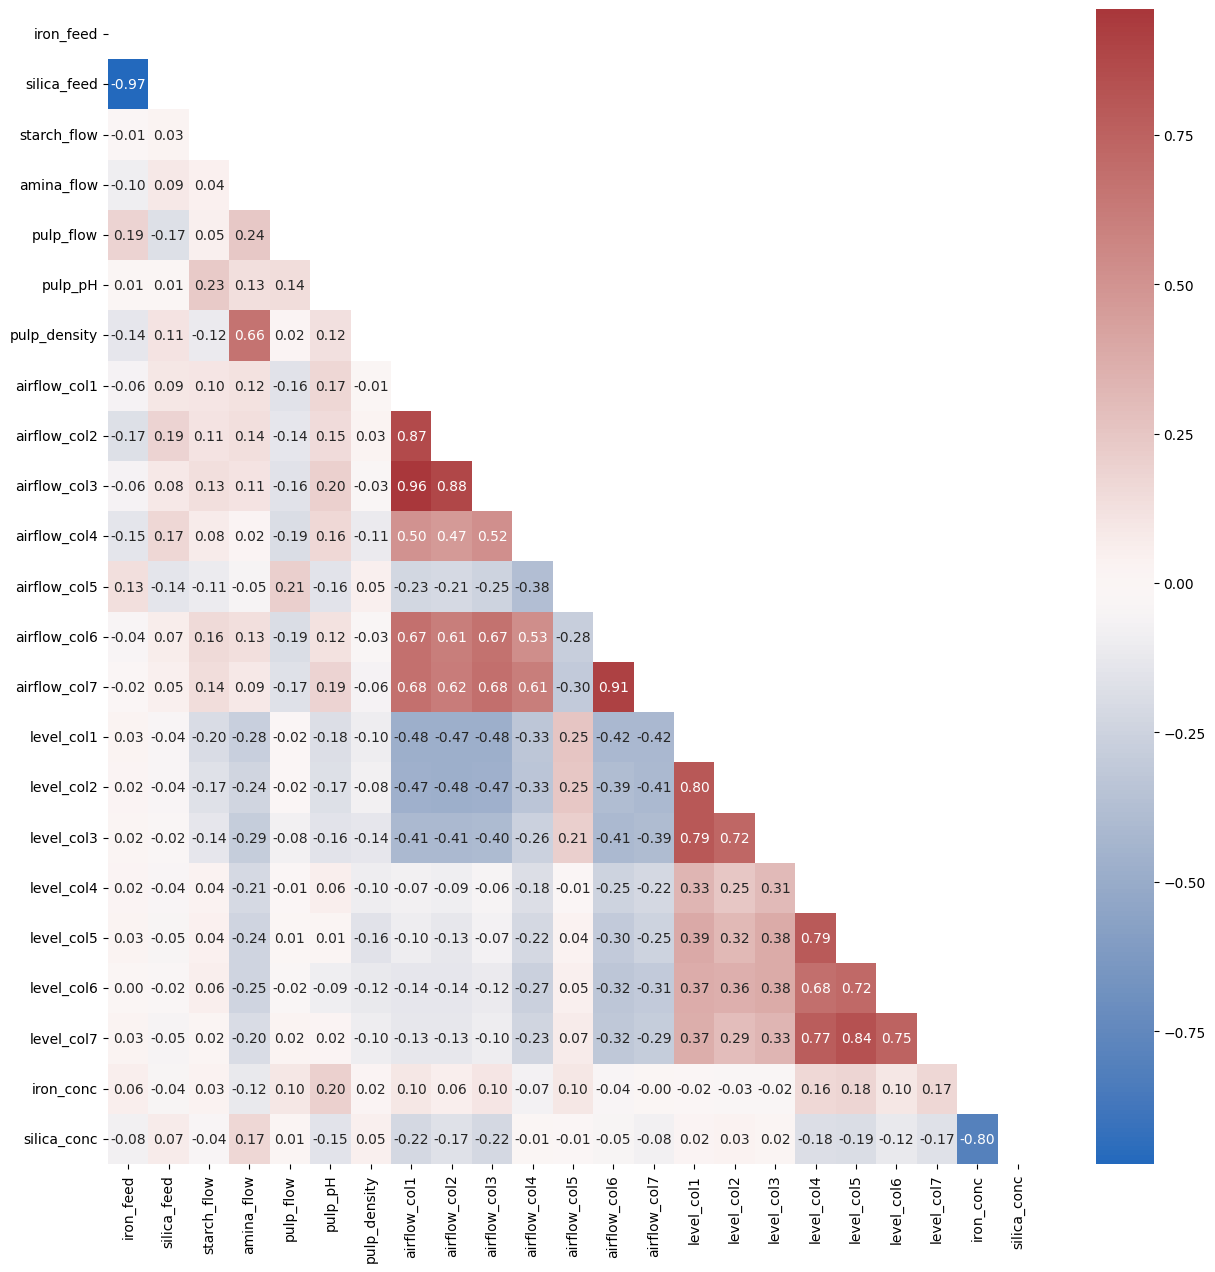

In [79]:
mask = np.triu(np.ones_like(flotation_scaled.corr(), dtype=bool))
plt.figure(figsize=(15, 15))
sns.heatmap(flotation_scaled.corr(), annot=True, fmt='.2f', cmap='vlag', 
            annot_kws={"fontsize": 10}, mask=mask)
plt.show()

###**4.6. Check & remove outliers**

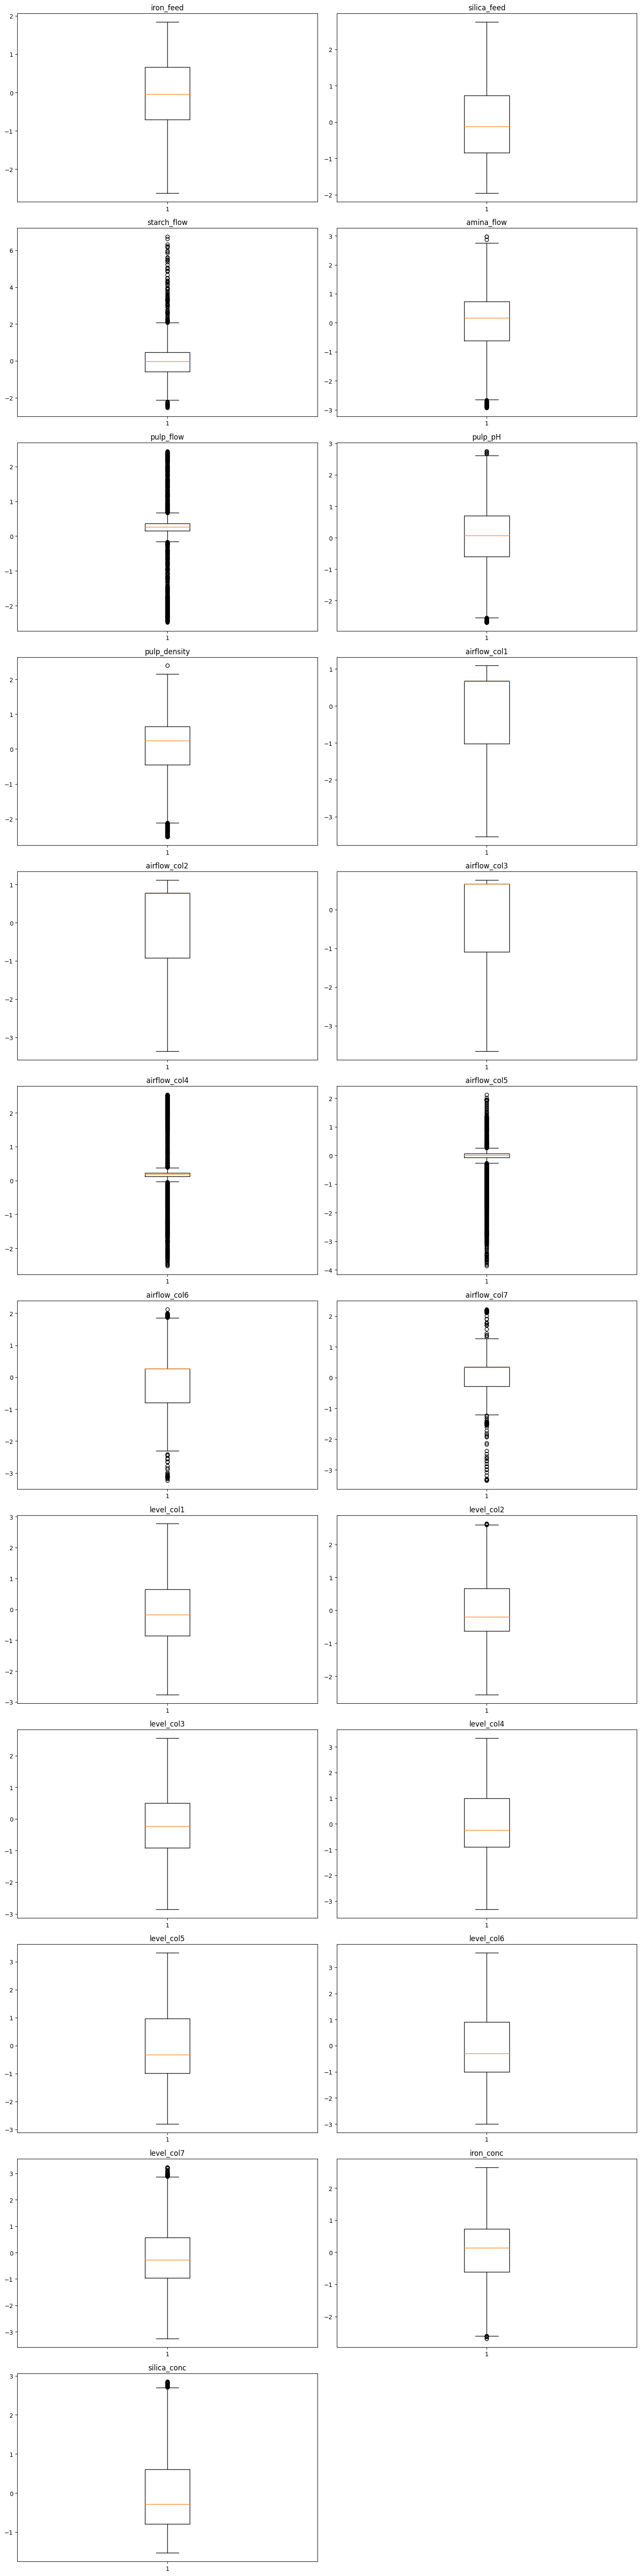

In [80]:
variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col1', 'airflow_col2',
       'airflow_col3', 'airflow_col4', 'airflow_col5', 'airflow_col6',
       'airflow_col7', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
       'level_col5', 'level_col6', 'level_col7', 'iron_conc', 'silica_conc']

num_rows = (len(variables) + 1) // 2 
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(15, num_rows * 5))

axes = axes.flatten()

for i, variable in enumerate(variables):
    data = flotation_scaled[variable]
    axes[i].boxplot(data)
    axes[i].set_title(variable)

for j in range(len(variables), 
               num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [81]:
from scipy.stats import mstats

variables = ['starch_flow', 'amina_flow', 'pulp_flow',
             'pulp_pH', 'pulp_density', 'airflow_col4', 
             'airflow_col5', 'airflow_col6', 'airflow_col7', 
             'level_col2', 'level_col7', 
             'iron_conc', 'silica_conc']

limits = {'starch_flow': [0.05, 0.05],
          'amina_flow': [0.03, 0.01],
          'pulp_flow': [0.2, 0.1],
          'pulp_pH': [0.05, 0.05],
          'pulp_density': [0.1, 0.01],
          'airflow_col4': [0.25, 0.25],
          'airflow_col5': [0.2, 0.2],
          'airflow_col6': [0.2, 0.2],
          'airflow_col7': [0.25, 0.10],
          'level_col2': [0.01, 0.01],
          'level_col7': [0.01, 0.02],
          'iron_conc': [0.01, 0.01],
          'silica_conc': [0.01, 0.02]
          }

for variable in variables:
    data = flotation_scaled[variable]
    limit = limits[variable]
    data_winsorized = winsorize(data, limits=limit)
    flotation_scaled[variable] = data_winsorized

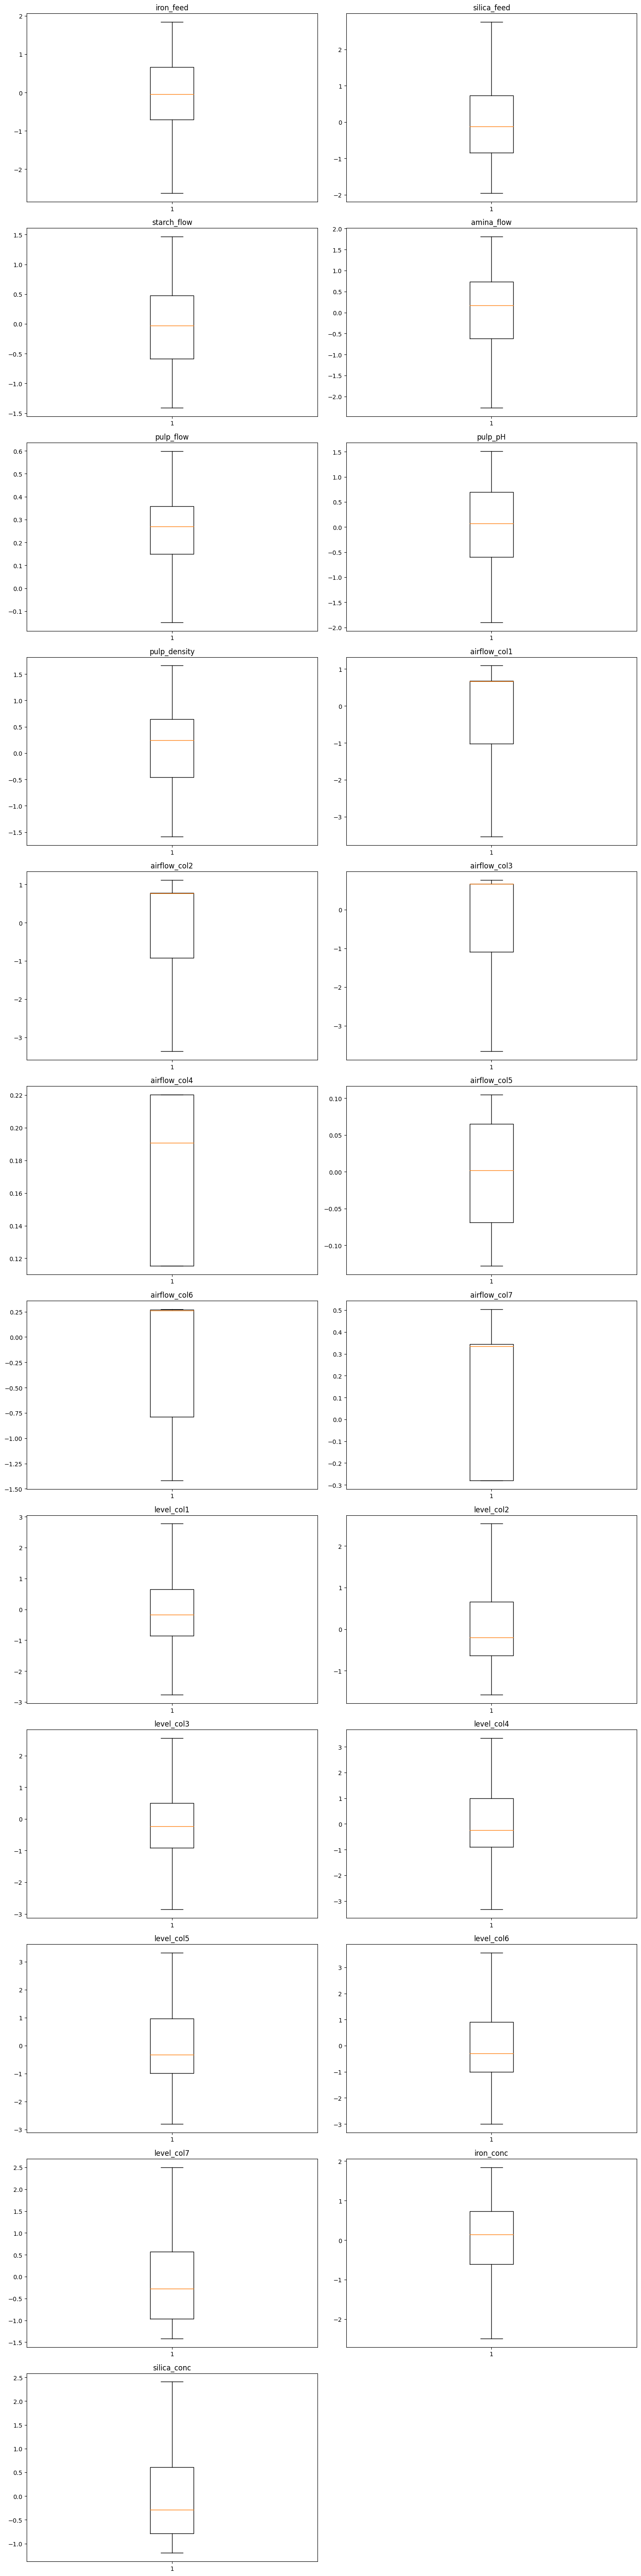

In [82]:
variables = ['iron_feed', 'silica_feed', 'starch_flow', 'amina_flow', 'pulp_flow',
       'pulp_pH', 'pulp_density', 'airflow_col1', 'airflow_col2',
       'airflow_col3', 'airflow_col4', 'airflow_col5', 'airflow_col6',
       'airflow_col7', 'level_col1', 'level_col2', 'level_col3', 'level_col4',
       'level_col5', 'level_col6', 'level_col7', 'iron_conc', 'silica_conc']

num_rows = (len(variables) + 1) // 2 
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, 
                         figsize=(15, num_rows * 5))

axes = axes.flatten()

for i, variable in enumerate(variables):
    data = flotation_scaled[variable]
    axes[i].boxplot(data)
    axes[i].set_title(variable)

for j in range(len(variables), 
               num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

###**4.8. Save manipulated dataset to new file**

In [83]:
flotation_scaled.to_csv('/content/drive/My Drive/Flotation/flotation_scaled.csv', index=False)